## Imports

In [1]:
import numpy as np
import pandas as pd
from statsmodels.api import OLS
from scipy import stats
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
import nltk
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import gensim
import warnings
warnings.filterwarnings('ignore')

## Hotel Dataset

In [2]:
df = pd.read_csv('ScrapedHotels.csv')

In [3]:
df.describe()
df.dtypes

Title            object
Rank             object
Rating          float64
Reviews          object
Amenities        object
RoomFeatures     object
RoomTypes        object
Class           float64
Style            object
Description      object
Website           int64
Offers            int64
Covid             int64
Location        float64
Cleanliness     float64
Value           float64
Service         float64
Walkscore       float64
Restaurants     float64
Attractions     float64
ImageCount       object
Price            object
dtype: object

In [4]:
df = df[df['Rating'].notnull()]

## Data Processing

In [5]:
df['Rank'] = df['Rank'].str[1:].str.replace(',','').astype(int)
df['Reviews'] = df['Reviews'].str.replace(',','').astype(int)
df['Description'] = df['Description'].astype(str)
df['ImageCount'] = df['ImageCount'].str.replace(',','').astype(int)
df['Class'].fillna('NA', inplace=True)
df['Class'] = df['Class'].astype('category')
df['Covid'] = df['Covid'].astype('category')
df['Website'] = df['Website'].astype('category')
df['Offers'] = df['Offers'].astype('category')
df['Location'].fillna(df['Location'].mean(), inplace=True)
df['Cleanliness'].fillna(df['Cleanliness'].mean(), inplace=True)
df['Value'].fillna(df['Value'].mean(), inplace=True)
df['Service'].fillna(df['Service'].mean(), inplace=True)
df['RoomTypes'].fillna('NA', inplace=True)

## Covid Safety T-tests

In [6]:
has_csafe = df.loc[df['Covid'] == 1,'Rank']
no_csafe = df.loc[df['Covid'] == 0, 'Rank']
print('Two-sided t-test on average rank of hotels with and without covid safety measures\n', stats.ttest_ind(has_csafe, no_csafe, equal_var=False))
print('One-sided t-test on average rank of hotels with and without covid safety measures\n', stats.ttest_ind(has_csafe, no_csafe, equal_var=False, alternative='greater'))


Two-sided t-test on average rank of hotels with and without covid safety measures
 Ttest_indResult(statistic=-40.1278287487386, pvalue=1.3049372263839034e-277)
One-sided t-test on average rank of hotels with and without covid safety measures
 Ttest_indResult(statistic=-40.1278287487386, pvalue=1.0)


It is recommended for the new or existing hotels to have the COVID safety measures implemented and have it listed on their Tripadvisor page

## Non-Smoking Room Z Test

In [7]:
df['RoomTypes'] = df['RoomTypes'].str.replace("[", "")
df['RoomTypes'] = df['RoomTypes'].str.replace("]", "")
df['RoomTypes'] = df['RoomTypes'].str.replace("'", "")

df['NonSmokingRoom'] = pd.np.where(df['RoomTypes'].str.contains("Non-smoking"), 1,0)
nonsmokingroom = df['NonSmokingRoom'].value_counts().to_frame('Count')
nonsmokingroom

non_smoking_hotels_high_rated = df.loc[((df['NonSmokingRoom']==1) & (df['Rating']>=4)) , :]
no_non_smoking_hotels_high_rated = df.loc[((df['NonSmokingRoom']==0) & (df['Rating']>=4)) , :]

In [8]:
significance = 0.025

sample_success_a, sample_size_a = (len(non_smoking_hotels_high_rated), nonsmokingroom.loc[1, 'Count'])
sample_success_b, sample_size_b = (len(no_non_smoking_hotels_high_rated),nonsmokingroom.loc[0, 'Count'])

successes = np.array([sample_success_a, sample_success_b])
samples = np.array([sample_size_a, sample_size_b])

stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')

print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))

if p_value > significance:
    print ("Fail to reject the null hypothesis")
else:
    print ("Reject the null hypothesis - suggest the alternative hypothesis is true")

z_stat: 5.515, p_value: 0.000
Reject the null hypothesis - suggest the alternative hypothesis is true


In [9]:
stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='smaller')
if p_value > 0.05:
    print ("Fail to reject the null hypothesis")
else:
    print ("Reject the null hypothesis - suggest the alternative hypothesis is true")

Fail to reject the null hypothesis


The test above is a z-test for proportions to test if having non-smoking rooms leads to more ratings of 4 and 5.
It is recommended for the hotels to have or convert some of their rooms to Non-Smoking rooms

## Description Length T-Test

In [10]:
desc = df['Description'].to_list()
tokenized_desc = [nltk.word_tokenize(i.lower()) for i in desc]

In [11]:
df['DescLength'] = pd.Series([len(i) for i in tokenized_desc])
df['DescLength'].fillna(0, inplace=True)

In [12]:
no_desc = df.loc[df['DescLength'] <=100,'Rank']
yes_desc = df.loc[df['DescLength'] >100, 'Rank']
print('Two-sided t-test on average rank of hotels with and without more than 100 word description\n', stats.ttest_ind(yes_desc, no_desc, equal_var=False))
print('One-sided t-test on average rank of hotels with and without more than 100 word description\n', stats.ttest_ind(yes_desc, no_desc, equal_var=False, alternative='greater'))


Two-sided t-test on average rank of hotels with and without more than 100 word description
 Ttest_indResult(statistic=-23.872020811730128, pvalue=4.077080926147091e-115)
One-sided t-test on average rank of hotels with and without more than 100 word description
 Ttest_indResult(statistic=-23.872020811730128, pvalue=1.0)


It is advised to provide a more detailed description of hotel for the guests to make an informed decision on their stay

## Restaurants T-test

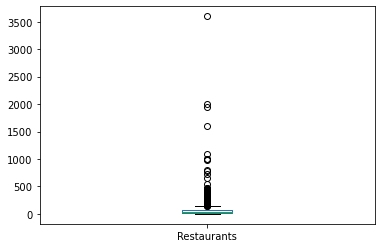

In [13]:
df['Restaurants'].plot.box()

In [14]:
df['Restaurants'].quantile([0.5, 0.75])

0.50    40.0
0.75    73.0
Name: Restaurants, dtype: float64

In [15]:
res_more40 = df[df['Restaurants']>40]['Rank']
res_less40 =  df[df['Restaurants']<=40]['Rank']
print("Two-sided t-test on average rank of hotels with near by restaurants more than 40\n",stats.ttest_ind(res_more40, res_less40, equal_var=False))
      

Two-sided t-test on average rank of hotels with near by restaurants more than 40
 Ttest_indResult(statistic=-6.871753967349365, pvalue=8.548849988173598e-12)


In [16]:
print("One-sided t-test on average rank of hotels with near by restaurants more than 40\n",stats.ttest_ind(res_more40, res_less40, equal_var=False, alternative='greater'))


One-sided t-test on average rank of hotels with near by restaurants more than 40
 Ttest_indResult(statistic=-6.871753967349365, pvalue=0.9999999999957256)


## Attractions T-test

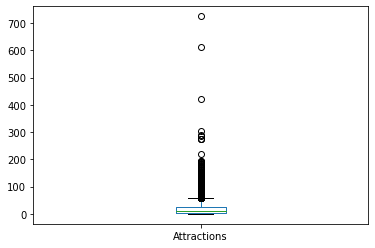

In [17]:
df['Attractions'].plot.box()

In [18]:
df['Attractions'].quantile([0.5, 0.75])

0.50    11.0
0.75    26.0
Name: Attractions, dtype: float64

In [19]:
att_more11 = df[df['Attractions']>11]['Rank']
att_less11 =  df[df['Attractions']<=11]['Rank']
print("Two-sided t-test on average rank of hotels with near by attractions more than 11\n",stats.ttest_ind(att_more11, att_less11, equal_var=False))


Two-sided t-test on average rank of hotels with near by attractions more than 11
 Ttest_indResult(statistic=-1.0891240692467286, pvalue=0.27623700139806384)


 New upcoming hotels need not spend a fortune paying for a premiere locations that are near multiple attractions

## T-test on Offers, Rating, Website and ImageCount

In [20]:
offer_df = df[df['Offers']==0]['Rank']
no_offer_df =  df[df['Offers']==1]['Rank']

print('Two-sided t-test on average rating of hotels with and without offers listed\n', stats.ttest_ind(offer_df, no_offer_df, equal_var=False))


Two-sided t-test on average rating of hotels with and without offers listed
 Ttest_indResult(statistic=31.861546833726916, pvalue=6.736410947065943e-155)


In [21]:
toprating_df = df[df['Rating']>=4]['Reviews']
lowrating_df =  df[df['Rating']<4]['Reviews']
print('Two-sided t-test on average number of reviews for high and low rated hotels offers listed\n', stats.ttest_ind(toprating_df, lowrating_df, equal_var=False))


Two-sided t-test on average number of reviews for high and low rated hotels offers listed
 Ttest_indResult(statistic=7.1304583023557635, pvalue=5.931662011174665e-12)


In [22]:
has_website = df.loc[df['Website'] == 1,'Rank']
no_website = df.loc[df['Website'] == 0, 'Rank']
print('Two-sided t-test on average rating of hotels with and without website listed\n', stats.ttest_ind(has_website, no_website, equal_var=False))
print('One-sided t-test on average rating of hotels with and without website listed\n', stats.ttest_ind(has_website, no_website, equal_var=False, alternative='greater'))


Two-sided t-test on average rating of hotels with and without website listed
 Ttest_indResult(statistic=-36.2911404112795, pvalue=9.091036801840072e-233)
One-sided t-test on average rating of hotels with and without website listed
 Ttest_indResult(statistic=-36.2911404112795, pvalue=1.0)


In [23]:
high_img = df.loc[df['ImageCount'] <=109,'Rank']
low_img = df.loc[df['ImageCount'] >109, 'Rank']
print('Two-sided t-test on average rating of hotels with and without more than 109 images\n', stats.ttest_ind(high_img, low_img, equal_var=False))
print('One-sided t-test on average rating of hotels with and without more than 109 images\n', stats.ttest_ind(high_img, low_img, equal_var=False, alternative='greater'))


Two-sided t-test on average rating of hotels with and without more than 109 images
 Ttest_indResult(statistic=46.14095769998473, pvalue=0.0)
One-sided t-test on average rating of hotels with and without more than 109 images
 Ttest_indResult(statistic=46.14095769998473, pvalue=0.0)


In [24]:
df = df.reset_index().dropna().set_index('index')

## Correlation matrix to remove redundant variables

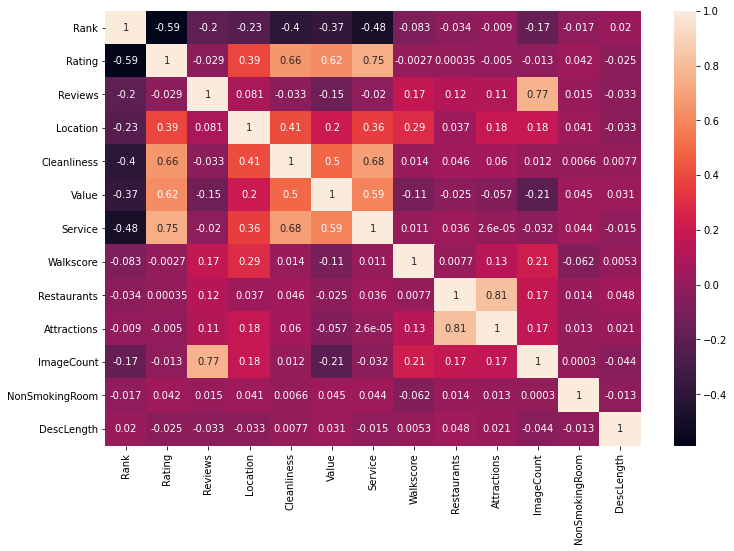

In [25]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

#### High correlation between Restaurants and Attractions--- Dropping Restaurants from linear regression model

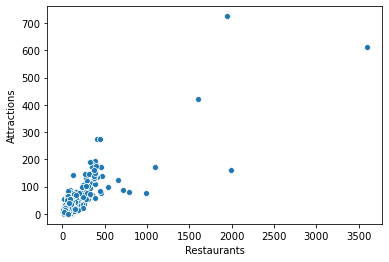

In [26]:
sns.scatterplot(df.Restaurants,df.Attractions)

## Linear Regression

In [27]:
X = df[['Rating', 'Reviews', 'Class', 'Website', 'Covid','Location', 'DescLength','Walkscore','Attractions', 'Offers', 'NonSmokingRoom']].copy()

X = pd.get_dummies(X, drop_first=True)
y = df.loc[:, ['Rank']]

In [28]:
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)

coef_dict = {}
for coef, feat in zip(reg.coef_.tolist()[0],X.columns):
    coef_dict[feat] = coef

0.43844686123672216
[[-7.29023663e+02 -5.71073549e-02  2.08734090e+01  1.08412469e-01
  -1.31955781e+00  1.66661593e-02 -3.51155967e+01 -3.25648405e+02
  -1.38194000e+02 -1.39457236e+02 -1.76354820e+02 -1.22391851e+02
  -1.60390491e+02 -1.18015747e+01 -1.89124281e+02 -1.24256161e-12
  -2.86772551e+01 -1.54883785e+02 -1.36000756e+01]]
[4219.28124086]


In [29]:
OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Rank   R-squared (uncentered):                   0.811
Model:                            OLS   Adj. R-squared (uncentered):              0.808
Method:                 Least Squares   F-statistic:                              238.4
Date:                Tue, 07 Dec 2021   Prob (F-statistic):                        0.00
Time:                        02:45:38   Log-Likelihood:                         -7394.5
No. Observations:                1016   AIC:                                  1.482e+04
Df Residuals:                     998   BIC:                                  1.491e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Rating          -571.0912     36.570    -15.616      0.000    -642.855    -499.328
Reviews           -0.0576      0.010     -5.567      0.000      -0.078      -0.037
Location         210.2930     39.097      5.379      0.000     133.570     287.016
DescLength         0.3800      0.159      2.390      0.017       0.068       0.692
Walkscore         -0.4475      0.591     -0.757      0.449      -1.607       0.712
Attractions       -0.1173      0.249     -0.471      0.637      -0.606       0.371
NonSmokingRoom  1395.5738    147.312      9.474      0.000    1106.497    1684.650
Class_1.5        940.9198    242.839      3.875      0.000     464.386    1417.454
Class_2.0       1045.5860    137.760      7.590      0.000     775.253    1315.919
Class_2.5        985.8999    146.786      6.717      0.000     697.855    1273.945
Class_3.0        938.6044    140.179      6.696      0.000     663.524    1213.684
Class_3.5        986.3905    145.768      6.767      0.000     700.343    1272.438
Class_4.0        959.8475    141.762      6.771      0.000     681.662    1238.033
Class_4.5       1046.5897    204.141      5.127      0.000     645.995    1447.184
Class_5.0        875.4818    156.923      5.579      0.000     567.545    1183.418
Class_NA        1.982e-13   2.82e-14      7.036      0.000    1.43e-13    2.53e-13
Website_1        -26.2442     29.066     -0.903      0.367     -83.281      30.793
Covid_1         -141.9898     25.626     -5.541      0.000    -192.277     -91.702
Offers_1           6.2439     30.631      0.204      0.839     -53.864      66.352
==============================================================================
Omnibus:                       55.863   Durbin-Watson:                   0.620
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.323
Skew:                           0.412   Prob(JB):                     2.00e-21
Kurtosis:                       4.254   Cond. No.                     3.13e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.74e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Reviews Dataset

In [32]:
r1 = pd.read_csv('hamptoninnreviews.csv')
r2 = pd.read_csv('howardjohnsonreviews.csv')
r3 = pd.read_csv('hollywoodhotelreviews.csv')
r4 = pd.read_csv('montereyplazareviews.csv')
r5 = pd.read_csv('hollywoodrooseveltreviews.csv')
r6 = pd.read_csv('shorecliffeviews.csv')
r7 = pd.read_csv('hotelcorquereviews.csv')
r8 = pd.read_csv('shorehotelreviews.csv')
r9 = pd.read_csv('hotelemblumreviews.csv')
r10 = pd.read_csv('theanaheimreviews.csv')

In [33]:
reviews= r1.append(r2).append(r3).append(r4).append(r5).append(r6).append(r7).append(r8).append(r9).append(r10)

In [34]:
reviews.count()

username             24904
contributions        24905
location             14013
staydate             24785
triptype             24785
reviewdate           24905
overallrating        24905
revtitle             24904
reviewtext           24905
roomtip               4709
value                13136
service              17030
sleepquality         11894
locationrev          12874
rooms                12807
cleanliness          13336
responder            16323
responderposition    16363
responsedate         16364
response             16364
helpful              24905
dtype: int64

In [35]:
reviews

,username,contributions,location,staydate,triptype,reviewdate,overallrating,revtitle,reviewtext,roomtip,...,service,sleepquality,locationrev,rooms,cleanliness,responder,responderposition,responsedate,response,helpful
0,Christian Patri... A,1,NaN,2021-11-30,FAMILY,2021-11-30,5,"Convenient location, clean facilities, friendl...",Place was convenient for our needs and staff w...,Adrian at the front desk was very helpful and ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,CDWAS,29,Louisiana,2021-07-31,FAMILY,2021-07-22,5,Good Stay But Breakfast Could Be Better,My family and I recently spent 3 nights at thi...,NaN,...,NaN,NaN,NaN,NaN,NaN,Brenna Simpson,Guest Services / Front Office,2021-07-27,Thank you for taking the time to leave a revie...,11
2,llatakayama,1,"Mililani, Hawaii",2021-11-30,NONE,2021-11-29,4,Great location to the Toy Story shuttle,Clean large rooms. Bunk beds were great. Fam...,NaN,...,4.0,4.0,5.0,5.0,4.0,NaN,NaN,NaN,NaN,0
3,Redhead84,2,NaN,2021-11-30,COUPLES,2021-11-26,5,Great Service,We had a great experience checking in. Adrian ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Joe L,1,"Oakland, California",2021-11-30,FAMILY,2021-11-26,5,Adrian you rock!!,"Upon arriving to the facility, the lobby was v...",Talk to front desk agent Adrian. Very helpful ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,Catalina,1,NaN,2021-12-31,FAMILY,2021-12-02,5,Very friendly staff,Anaheim Hotel is a classic. All the staff were...,NaN,...,NaN,NaN,NaN,NaN,NaN,Candi Crowe,Guest Services / Front Office,2021-12-04,"Hello Catalina,\n\nWe thank you for taking the...",0
681,Cindy M,6,NaN,2020-02-29,NONE,2020-02-23,5,Back at the Anaheim Hotel,This is such a great property! The staff of T...,NaN,...,5.0,NaN,NaN,NaN,5.0,Robert Flores,Guest Services / Front Office,2020-02-23,"Dear Cindy M,\n\nThank you for your feedback.W...",13
682,Darcell B,1,NaN,2021-11-30,FAMILY,2021-12-02,5,Disneyland vacation,Rented a scooter and needed help and the hotel...,NaN,...,NaN,NaN,NaN,NaN,NaN,Candi Crowe,Guest Services / Front Office,2021-12-04,"Hello Darcell,\n\nWe thank you for taking the ...",0
683,Desiree J,1,NaN,2021-11-30,FAMILY,2021-11-29,5,Leo is a saint,Leo was so sweet and caring . He spotted my da...,NaN,...,NaN,NaN,NaN,NaN,NaN,Candi Crowe,Guest Services / Front Office,2021-11-30,"Hello Desiree,\n\nWe thank you for taking the ...",0


## Sentiment Analysis

In [36]:
def calculate_polarity(dataset, value, negvalue):
    textdf = dataset.copy()
    textdf['Polarity'] = textdf['review'].map(lambda text: TextBlob(text).sentiment.polarity)
    textdf['Polarity_Type'] = 0
    for i in range(len(textdf)):
        if (textdf.loc[i, 'Polarity'] >= value):
            textdf.loc[i, 'Polarity_Type'] = 'Positive'
        elif (textdf.loc[i, 'Polarity'] <= negvalue):
            textdf.loc[i, 'Polarity_Type'] = 'Negative'
        elif (textdf.loc[i, 'Polarity'] > negvalue and textdf.loc[i, 'Polarity'] < value):
            textdf.loc[i, 'Polarity_Type'] = 'Neutral'
    textdf['Feedback_len'] = textdf['review'].astype(str).apply(len)
    textdf['Word_count'] = textdf['review'].map(lambda x: len(str(x).split()))
    return textdf

## Sentiment Analysis for Location California/Not California

In [37]:
reviews['CA']=0 
reviews['CA'] = pd.np.where(reviews.location.str.contains("Cali"), 1,0)
reviews_not_null_location= reviews[reviews['location'].notnull()]

In [38]:
reviews_cali=reviews_not_null_location[(reviews_not_null_location['CA']==1)]
reviews_non_cali=reviews_not_null_location[(reviews_not_null_location['CA']==0)]

In [39]:
#Tokenize each review in the collection
c_cali=[]
for i,r in reviews_cali.iterrows():
    i = nltk.word_tokenize(r['reviewtext'])
    c_cali.append(i)

#Use the tokenized reviews after step 1, lemmatize all the words, convert in lowercase

lemmatizer_cali = nltk.stem.WordNetLemmatizer()
lemmatizedc_cali = []
for document in c_cali:
    lemmatized_token_cali = [lemmatizer_cali.lemmatize(token).lower() for token in document if token.isalpha()]
    lemmatizedc_cali.append(lemmatized_token_cali)
# print(lemmatizedc_holiday)

#Based on the output in step 2, remove all the stop-words and the punctuations
stop_words_removed_c_cali=[]
from nltk.corpus import stopwords
for lemmatized_document_cali in lemmatizedc_cali:
    stop_words_removed = [token for token in lemmatized_document_cali if not token in stopwords.words('english') if token.isalpha()]
    stop_words_removed_c_cali.append(stop_words_removed)
# print(stop_words_removed_c_holiday)

list_afterstopwords_cali = []
for words in stop_words_removed_c_cali:
        list_afterstopwords_cali.append(" ".join(words))
        

In [40]:
#Tokenize each review in the collection
c_non_cali=[]
for i,r in reviews_non_cali.iterrows():
    i = nltk.word_tokenize(r['reviewtext'])
    c_non_cali.append(i)

#Use the tokenized reviews after step 1, lemmatize all the words, convert in lowercase

lemmatizer_non_cali = nltk.stem.WordNetLemmatizer()
lemmatizedc_non_cali = []
for document in c_non_cali:
    lemmatized_token_non_cali = [lemmatizer_non_cali.lemmatize(token).lower() for token in document if token.isalpha()]
    lemmatizedc_non_cali.append(lemmatized_token_non_cali)
# print(lemmatizedc_holiday)

#Based on the output in step 2, remove all the stop-words and the punctuations
stop_words_removed_c_non_cali=[]
from nltk.corpus import stopwords
for lemmatized_document_non_cali in lemmatizedc_non_cali:
    stop_words_removed = [token for token in lemmatized_document_non_cali if not token in stopwords.words('english') if token.isalpha()]
    stop_words_removed_c_non_cali.append(stop_words_removed)
# print(stop_words_removed_c_holiday)

list_afterstopwords_non_cali = []
for words in stop_words_removed_c_non_cali:
        list_afterstopwords_non_cali.append(" ".join(words))
        

In [41]:
cali = pd.DataFrame(list_afterstopwords_cali, columns=['review'])
cali_polar= calculate_polarity(cali,0.4,0.2)
cali_polar_values=cali_polar.groupby(["Polarity_Type"]).review.count()
cali_polar_values

Polarity_Type
Negative     838
Neutral     2182
Positive    2066
Name: review, dtype: int64

In [42]:
non_cali = pd.DataFrame(list_afterstopwords_non_cali, columns=['review'])
non_cali_polar= calculate_polarity(non_cali,0.4,0.2)
non_cali_polar_values=non_cali_polar.groupby(["Polarity_Type"]).review.count()
non_cali_polar_values

Polarity_Type
Negative    1716
Neutral     4139
Positive    3072
Name: review, dtype: int64

## Z Test on % Negative Sentiments (California/Non California)

In [43]:
significance = 0.025

sample_success_a, sample_size_a = (cali_polar_values[0], len(reviews_cali.index))
sample_success_b, sample_size_b = (non_cali_polar_values[0], len(reviews_non_cali.index))

successes = np.array([sample_success_a, sample_success_b])
samples = np.array([sample_size_a, sample_size_b])

stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')

print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))

if p_value > significance:
    print ("Fail to reject the null hypothesis")
else:
    print ("Reject the null hypothesis - suggest the alternative hypothesis is true")

z_stat: -4.049, p_value: 0.000
Reject the null hypothesis - suggest the alternative hypothesis is true


#### Single sided T-test

In [44]:
stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='smaller')
print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))
if p_value > 0.05:
    print ("Fail to reject the null hypothesis")
else:
    print ("Reject the null hypothesis - suggest the alternative hypothesis is true")

z_stat: -4.049, p_value: 0.000
Reject the null hypothesis - suggest the alternative hypothesis is true


#### Travelers from California have a significantly less negative sentiment towards Californian hotels than travelers from other locations

## Analyzing TripType-- Business 

In [45]:
reviews.triptype.unique()

array(['FAMILY', 'NONE', 'COUPLES', 'SOLO', 'FRIENDS', 'BUSINESS', nan],
      dtype=object)

In [46]:
business=reviews[(reviews['triptype']=='BUSINESS')]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018632BE4FA0>],
      dtype=object)

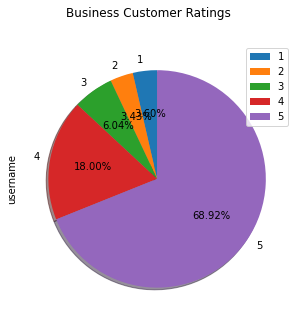

In [51]:
business=business.groupby(by="overallrating")
business[["username"]].count().plot(kind='pie', subplots=True, shadow = True,startangle=90, title = 'Business Customer Ratings',
figsize=(10,5), autopct='%.2f%%')

In [52]:
business=reviews[(reviews['triptype']=='BUSINESS')]
business_location= business[business['location'].notnull()].copy()

In [53]:
business_location['CA']=0 
business_location['CA'] = pd.np.where(business_location.location.str.contains("Cali"), 1,0)

business_cali=business_location[(business_location['CA']==1)]
business_non_cali=business_location[(business_location['CA']==0)]

print('Business trips by people in california: ',len(business_cali.index))
print('Business trips by people out of california: ',len(business_non_cali.index))

business_cali_goodrating=business_cali[(business_cali['overallrating']>=4)]
business_non_cali_goodrating=business_non_cali[(business_non_cali['overallrating']>=4)]

print('California 4/5 rating',len(business_cali_goodrating.index))
print('Non California 4/5 rating',len(business_non_cali_goodrating.index))

Business trips by people in california:  507
Business trips by people out of california:  868
California 4/5 rating 457
Non California 4/5 rating 734


## Z Test on Business Trips for Californians/ Non-Californians who gave 4 & 5 star rating

In [54]:
significance = 0.025

sample_success_a, sample_size_a = (len(business_cali_goodrating.index), len(business_cali.index))
sample_success_b, sample_size_b = (len(business_non_cali_goodrating.index), len(business_non_cali.index))

successes = np.array([sample_success_a, sample_success_b])
samples = np.array([sample_size_a, sample_size_b])

stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')

print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))

if p_value > significance:
    print ("Fail to reject the null hypothesis")
else:
    print ("Reject the null hypothesis - suggest the alternative hypothesis is true")

z_stat: 2.930, p_value: 0.003
Reject the null hypothesis - suggest the alternative hypothesis is true


## Single sided Z Test

In [55]:
stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='larger')
print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))
if p_value > 0.05:
    print ("Fail to reject the null hypothesis")
else:
    print ("Reject the null hypothesis - suggest the alternative hypothesis is true")

z_stat: 2.930, p_value: 0.002
Reject the null hypothesis - suggest the alternative hypothesis is true


#### Focusing on business travelers from other locations can help mitigate this lower % of 4 and 5 ratings 

## Topic Modelling for Hotel Description on Trip Advisor

In [57]:
#Tokenize each description in the collection
c=[]
z=1
for i,r in df.iterrows():
    if z < 101:
        i = nltk.word_tokenize(r['Description'])
        c.append(i)
        z=z+1
    else:
        break

#Use the tokenized description after step 1, lemmatize all the words, convert in lowercase

lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatizedc = []
for document in c:
    lemmatized_token = [lemmatizer.lemmatize(token).lower() for token in document if token.isalpha()]
    lemmatizedc.append(lemmatized_token)

#Based on the output in step 2, remove all the stop-words and the punctuations
stop_words_removed_c=[]
for lemmatized_document in lemmatizedc:
    stop_words_removed = [token for token in lemmatized_document if not token in stopwords.words('english') if token.isalpha()]
    stop_words_removed_c.append(stop_words_removed)

# Based on the output in step 3, convert each of the reviews in a Term document matrix.
# The minimal document frequency for each term is 5. Also, including 2-grams.

list_afterstopwords = []
for words in stop_words_removed_c:
        list_afterstopwords.append(" ".join(words))

vectorizer1 = CountVectorizer(ngram_range=(1, 2), min_df=5)
X2 = vectorizer1.fit_transform(list_afterstopwords)
terms = vectorizer1.get_feature_names()

# Found the top-10 terms (terms with the top-5 highest weights) for each of the 4 topics
dictionary = gensim.corpora.Dictionary(stop_words_removed_c)
bow_c4 = [dictionary.doc2bow(doc) for doc in stop_words_removed_c]
lda_model = gensim.models.LdaModel(bow_c4, num_topics=4, id2word=dictionary)
for idx, topic in lda_model.print_topics(num_words=10):
    print('Topic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.018*"hotel" + 0.010*"san" + 0.009*"beach" + 0.008*"guest" + 0.008*"diego" + 0.007*"room" + 0.006*"located" + 0.005*"california" + 0.005*"inn" + 0.005*"offer"
Topic: 1 
Words: 0.019*"hotel" + 0.010*"room" + 0.008*"san" + 0.007*"beach" + 0.007*"center" + 0.006*"guest" + 0.006*"located" + 0.006*"offer" + 0.006*"service" + 0.005*"los"
Topic: 2 
Words: 0.017*"hotel" + 0.010*"san" + 0.008*"beach" + 0.008*"room" + 0.007*"offer" + 0.007*"inn" + 0.006*"guest" + 0.006*"complimentary" + 0.006*"located" + 0.006*"restaurant"
Topic: 3 
Words: 0.021*"hotel" + 0.013*"room" + 0.010*"guest" + 0.009*"pool" + 0.009*"beach" + 0.007*"free" + 0.006*"breakfast" + 0.006*"inn" + 0.006*"santa" + 0.005*"center"


#### The top 100 hotel descriptions have been categorized into 4 different topics using topic modeling. Based on the top terms in each topic, we can say that travelers prefer hotels with restaurants, pool and beach nearby